# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


## Data Cleaning and Visualization of Badminton Data

This notebook demonstrates the process of cleaning and visualizing badminton data using Python and pandas. The dataset consists of two CSV files: `badmintondata.csv` and `badmintondata2.csv`. The goal is to combine the datasets, clean the data, and generate a 3D scatterplot for visualization.

### Data Loading and Cleaning

- The first step is to load the data from the CSV files using pandas' `read_csv` function.
- Missing values are handled by dropping rows with missing values using the `dropna` method.
- Outliers are identified and removed using the z-score method. Rows with z-scores exceeding a certain threshold are considered outliers and filtered out.
- Inconsistencies in the data, such as decimal separators, are addressed by replacing commas with periods and converting the data to float format.

### Data Combination

- The two datasets, `badmintondata.csv` and `badmintondata2.csv`, are combined into a single dataframe using pandas' `concat` function.

### Data Visualization

- A 3D scatterplot is generated to visualize the badminton data.
- Two scatterplots are shown side by side:
  - Cleaned Combined Dataset: The dataset after cleaning, with outliers removed and inconsistencies addressed.
  - Uncleaned Combined Dataset: The dataset before cleaning, with outliers and inconsistencies present.
- The scatterplots provide insights into the distribution and patterns of the data in three-dimensional space.


Number of rows before cleaning: 315200
Number of rows after cleaning: 168842


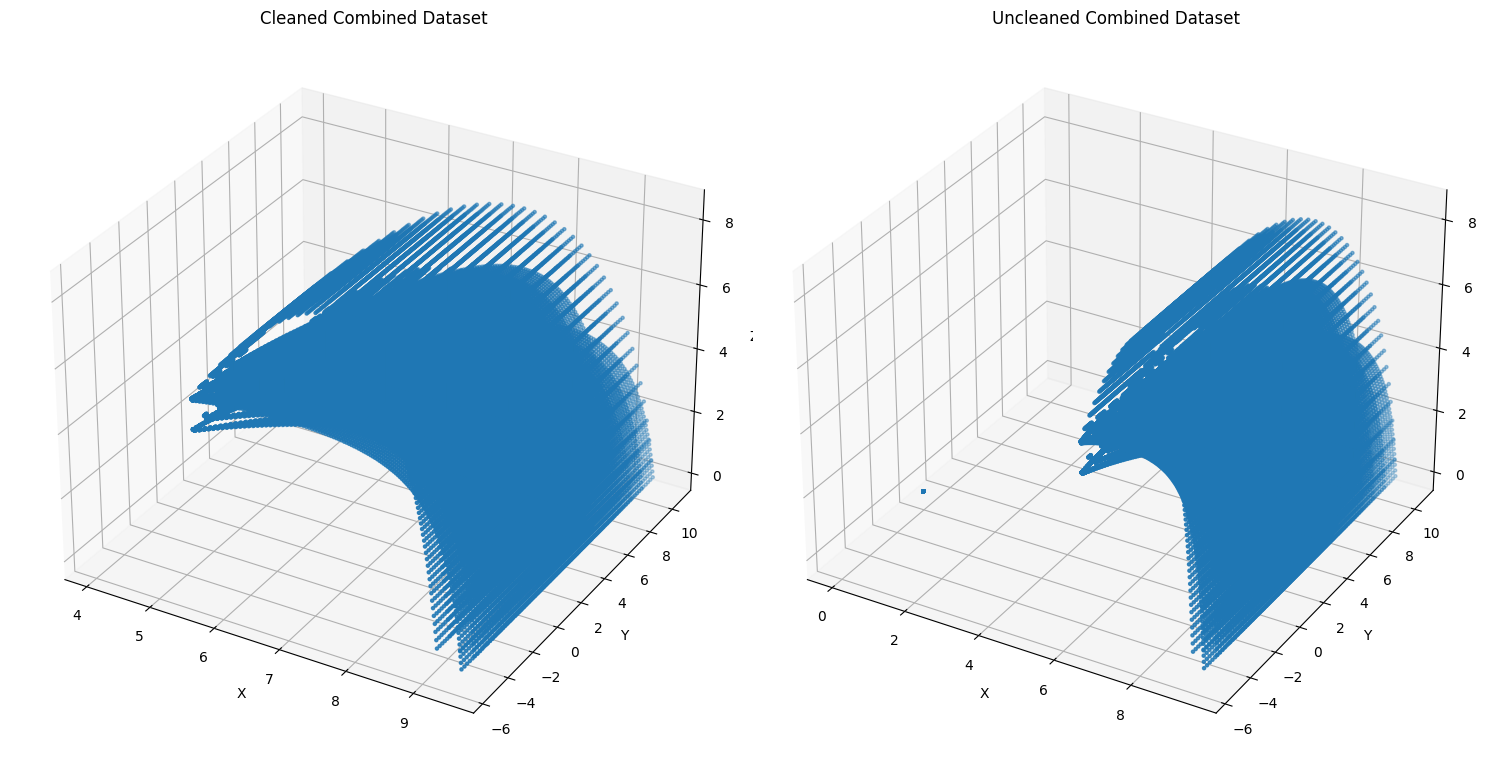

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the first dataset
df1 = pd.read_csv('badmintondata.csv')

# Load the second dataset
df2 = pd.read_csv('badmintondata2.csv')

# Combine both datasets
df_combined = pd.concat([df1, df2], ignore_index=True)

# Count rows before cleaning
rows_before_cleaning = df_combined.shape[0]

# Handling missing values
df_combined = df_combined.dropna()  # Drop rows with missing values

# Handling outliers (Using z-score)
z_scores_combined = (df_combined - df_combined.mean()) / df_combined.std()  # Calculate z-scores
threshold = 3  # Set a threshold for outliers
outliers_combined = (z_scores_combined.abs() > threshold).any(axis=1)  # Find rows with outliers
df_combined_cleaned = df_combined[~outliers_combined].copy()  # Filter out rows with outliers

# Identify consecutive rows of all zeros
mask = (df_combined == 0).all(axis=1)
groups = mask.cumsum()

# Filter out consecutive rows of all zeros
df_combined_cleaned = df_combined[~mask]
df_combined_cleaned.to_csv('cleaned_dataset.csv', index = False)

# Count rows after cleaning
rows_after_cleaning = df_combined_cleaned.shape[0]

print("Number of rows before cleaning:", rows_before_cleaning)
print("Number of rows after cleaning:", rows_after_cleaning)

# Generate scatterplot for the cleaned combined dataset
fig, axes = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': '3d'})

# Cleaned Combined Dataset
axes[0].scatter(df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(X) metres'], df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(Y) metres'], df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(Z) metres'], s=5)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_zlabel('Z')
axes[0].set_title('Cleaned Combined Dataset')
axes[0].grid(True)

# Uncleaned Combined Dataset
axes[1].scatter(df_combined['SHUTTLECOCK POSITIION IN AIR(X) metres'], df_combined['SHUTTLECOCK POSITIION IN AIR(Y) metres'], df_combined['SHUTTLECOCK POSITIION IN AIR(Z) metres'], s=5)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_zlabel('Z')
axes[1].set_title('Uncleaned Combined Dataset')
axes[1].grid(True)

plt.tight_layout()
plt.show()


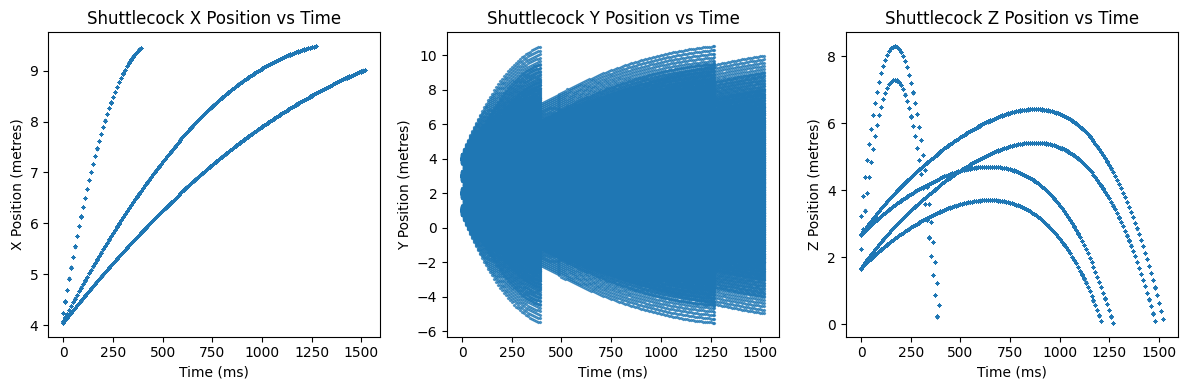

In [3]:
# Group the data before each group of zeros
grouped_df = df_combined_cleaned.groupby(groups, group_keys=False)

# Function to add a Time field to a group
def add_time_field(group):
    group['TIME'] = np.arange(len(group)) * 10  # Multiply by 10 to get time in ms
    return group

grouped_df = grouped_df.apply(add_time_field)

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the X position vs Time
axs[0].scatter(grouped_df['TIME'], grouped_df['SHUTTLECOCK POSITIION IN AIR(X) metres'], marker='x', s=2, alpha=0.8)
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('X Position (metres)')
axs[0].set_title('Shuttlecock X Position vs Time')

# Plot the Y position vs Time
axs[1].scatter(grouped_df['TIME'], grouped_df['SHUTTLECOCK POSITIION IN AIR(Y) metres'], marker='x', s=2, alpha=0.8)
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Y Position (metres)')
axs[1].set_title('Shuttlecock Y Position vs Time')

# Plot the Z position vs Time
axs[2].scatter(grouped_df['TIME'], grouped_df['SHUTTLECOCK POSITIION IN AIR(Z) metres'], marker='x', s=2, alpha=0.8)
axs[2].set_xlabel('Time (ms)')
axs[2].set_ylabel('Z Position (metres)')
axs[2].set_title('Shuttlecock Z Position vs Time')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


In [4]:
# Group the data before each group of zeros
grouped_df = df_combined_cleaned.groupby(groups)

# Split the groups into testing set and sample set (split into a testing set and a sample set using a 70:30 ratio)
train_groups, test_groups = train_test_split(list(grouped_df.groups), test_size=0.3, random_state=42)

# Create the training set
train_df = pd.concat([grouped_df.get_group(group) for group in train_groups])

# Create the testing set
test_df = pd.concat([grouped_df.get_group(group) for group in test_groups])

# Apply a TIME-based transformation to each group in the train and test data
train_df = train_df.groupby(groups, group_keys=False).apply(add_time_field)
test_df = test_df.groupby(groups, group_keys=False).apply(add_time_field)

In [5]:
# Define the non-feature columns
non_feature_cols = ["HUMAN PLAYER POSITION (X) metres", "HUMAN PLAYER POSITION (Y) metres",
                    "INITITAL VELOCITY OF SHUTTELCOCK(m/s)", "INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)",
                    "SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)", "TIME"]

# Define the feature columns
feature_cols = ["SHUTTLECOCK POSITIION IN AIR(X) metres", "SHUTTLECOCK POSITIION IN AIR(Y) metres",
                "SHUTTLECOCK POSITIION IN AIR(Z) metres"]

# Create the training feature DataFrame
train_features = train_df[feature_cols].copy()

# Create the training non-feature DataFrame
train_non_features = train_df[non_feature_cols].copy()

# Create the testing feature DataFrame
test_features = test_df[feature_cols].copy()

# Create the testing non-feature DataFrame
test_non_features = test_df[non_feature_cols].copy()

# Display the training feature DataFrame
print("Training Features:")
print(train_features.head())

# Display the training non-feature DataFrame
print("\nTraining Non-Features:")
print(train_non_features.head())

# Display the testing feature DataFrame
print("\nTesting Features:")
print(test_features.head())

# Display the testing non-feature DataFrame
print("\nTesting Non-Features:")
print(test_non_features.head())


Training Features:
        SHUTTLECOCK POSITIION IN AIR(X) metres  \
155400                                4.049012   
155401                                4.099699   
155402                                4.148521   
155403                                4.198738   
155404                                4.246939   

        SHUTTLECOCK POSITIION IN AIR(Y) metres  \
155400                                0.957395   
155401                                0.913333   
155402                                0.870893   
155403                                0.827240   
155404                                0.785339   

        SHUTTLECOCK POSITIION IN AIR(Z) metres  
155400                                2.685690  
155401                                2.770077  
155402                                2.854290  
155403                                2.934386  
155404                                3.012884  

Training Non-Features:
        HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITI

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Extract features and target variables
X_train = train_non_features
y_height_train = train_features["SHUTTLECOCK POSITIION IN AIR(Z) metres"].to_list()
y_side_train = train_features["SHUTTLECOCK POSITIION IN AIR(X) metres"].to_list()
y_forward_train = train_features["SHUTTLECOCK POSITIION IN AIR(Y) metres"].to_list()

# Create polynomial features
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)

# Train regression models for each target variable
reg_height = LinearRegression()
reg_height.fit(X_train_poly, y_height_train)

reg_side = LinearRegression()
reg_side.fit(X_train_poly, y_side_train)

reg_forward = LinearRegression()
reg_forward.fit(X_train_poly, y_forward_train)

# Evaluate regression models on the training set
y_height_train_pred = reg_height.predict(X_train_poly)
y_side_train_pred = reg_side.predict(X_train_poly)
y_forward_train_pred = reg_forward.predict(X_train_poly)

mse_height_train = mean_squared_error(y_height_train, y_height_train_pred)
mse_side_train = mean_squared_error(y_side_train, y_side_train_pred)
mse_forward_train = mean_squared_error(y_forward_train, y_forward_train_pred)

r2_score_height_train = r2_score(y_height_train, y_height_train_pred)
r2_score_side_train = r2_score(y_side_train, y_side_train_pred)
r2_score_forward_train = r2_score(y_forward_train, y_forward_train_pred)
print("Evaluate regression models on the training set")
print("Z predictor:")
print("  MSE on Train:", mse_height_train)
print("  R-squared on Train:", r2_score_height_train)

print("X predictor:")
print("  MSE on Train:", mse_side_train)
print("  R-squared on Train:", r2_score_side_train)

print("Y predictor:")
print("  MSE on Train:", mse_forward_train)
print("  R-squared on Train:", r2_score_forward_train)

# Evaluate regression models on the test set
X_test = test_non_features
y_height_test = test_features["SHUTTLECOCK POSITIION IN AIR(Z) metres"]
y_side_test = test_features["SHUTTLECOCK POSITIION IN AIR(X) metres"]
y_forward_test = test_features["SHUTTLECOCK POSITIION IN AIR(Y) metres"]

X_test_poly = poly.transform(X_test)

y_height_test_pred = reg_height.predict(X_test_poly)
y_side_test_pred = reg_side.predict(X_test_poly)
y_forward_test_pred = reg_forward.predict(X_test_poly)

mse_height_test = mean_squared_error(y_height_test, y_height_test_pred)
mse_side_test = mean_squared_error(y_side_test, y_side_test_pred)
mse_forward_test = mean_squared_error(y_forward_test, y_forward_test_pred)

r2_score_height_test = r2_score(y_height_test, y_height_test_pred)
r2_score_side_test = r2_score(y_side_test, y_side_test_pred)
r2_score_forward_test = r2_score(y_forward_test, y_forward_test_pred)
print("Evaluate regression models on the test set")
print("Z predictor:")
print("  MSE on Test:", mse_height_test)
print("  R-squared on Test:", r2_score_height_test)

print("X predictor:")
print("  MSE on Test:", mse_side_test)
print("  R-squared on Test:", r2_score_side_test)

print("Y predictor:")
print("  MSE on Test:", mse_forward_test)
print("  R-squared on Test:", r2_score_forward_test)


Evaluate regression models on the training set
Z predictor:
  MSE on Train: 0.13931628872009152
  R-squared on Train: 0.9485323037338713
X predictor:
  MSE on Train: 9.986022481853536e-07
  R-squared on Train: 0.9999995808953002
Y predictor:
  MSE on Train: 0.01158482109329221
  R-squared on Train: 0.9976886043088328
Evaluate regression models on the test set
Z predictor:
  MSE on Test: 0.14208386230418468
  R-squared on Test: 0.9484825218655009
X predictor:
  MSE on Test: 9.937312510466777e-07
  R-squared on Test: 0.9999995856173224
Y predictor:
  MSE on Test: 0.012620010617654834
  R-squared on Test: 0.9975203654981916


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, max_error

# Use the trained models to make predictions on the test set
X_test_poly = poly.transform(X_test)

predicted_height = reg_height.predict(X_test_poly)
predicted_side = reg_side.predict(X_test_poly)
predicted_forward = reg_forward.predict(X_test_poly)

# Calculate RMSE for each target variable
rmse_height = mean_squared_error(y_height_test, predicted_height, squared=False)
rmse_side = mean_squared_error(y_side_test, predicted_side, squared=False)
rmse_forward = mean_squared_error(y_forward_test, predicted_forward, squared=False)

# Calculate MAE for each target variable
mae_height = mean_absolute_error(y_height_test, predicted_height)
mae_side = mean_absolute_error(y_side_test, predicted_side)
mae_forward = mean_absolute_error(y_forward_test, predicted_forward)

# Calculate explained variance score for each target variable
evs_height = explained_variance_score(y_height_test, predicted_height)
evs_side = explained_variance_score(y_side_test, predicted_side)
evs_forward = explained_variance_score(y_forward_test, predicted_forward)

# Calculate maximum error for each target variable
max_error_height = max_error(y_height_test, predicted_height)
max_error_side = max_error(y_side_test, predicted_side)
max_error_forward = max_error(y_forward_test, predicted_forward)

# Print evaluation metrics for each model
print("Z (height) predictor:")
print("  RMSE:", rmse_height)
print("  MAE:", mae_height)
print("  Explained Variance Score:", evs_height)
print("  Maximum Error:", max_error_height)

print("X (side) predictor:")
print("  RMSE:", rmse_side)
print("  MAE:", mae_side)
print("  Explained Variance Score:", evs_side)
print("  Maximum Error:", max_error_side)

print("Y (forward) predictor:")
print("  RMSE:", rmse_forward)
print("  MAE:", mae_forward)
print("  Explained Variance Score:", evs_forward)
print("  Maximum Error:", max_error_forward)


Z (height) predictor:
  RMSE: 0.3769401309282214
  MAE: 0.30757079789957986
  Explained Variance Score: 0.9484832104307737
  Maximum Error: 0.9439400300946179
X (side) predictor:
  RMSE: 0.000996860697914547
  MAE: 0.00079558644197449
  Explained Variance Score: 0.9999995856413176
  Maximum Error: 0.00432409012430135
Y (forward) predictor:
  RMSE: 0.1123388206171617
  MAE: 0.07296522062893641
  Explained Variance Score: 0.9975204162367256
  Maximum Error: 1.0248720675999505


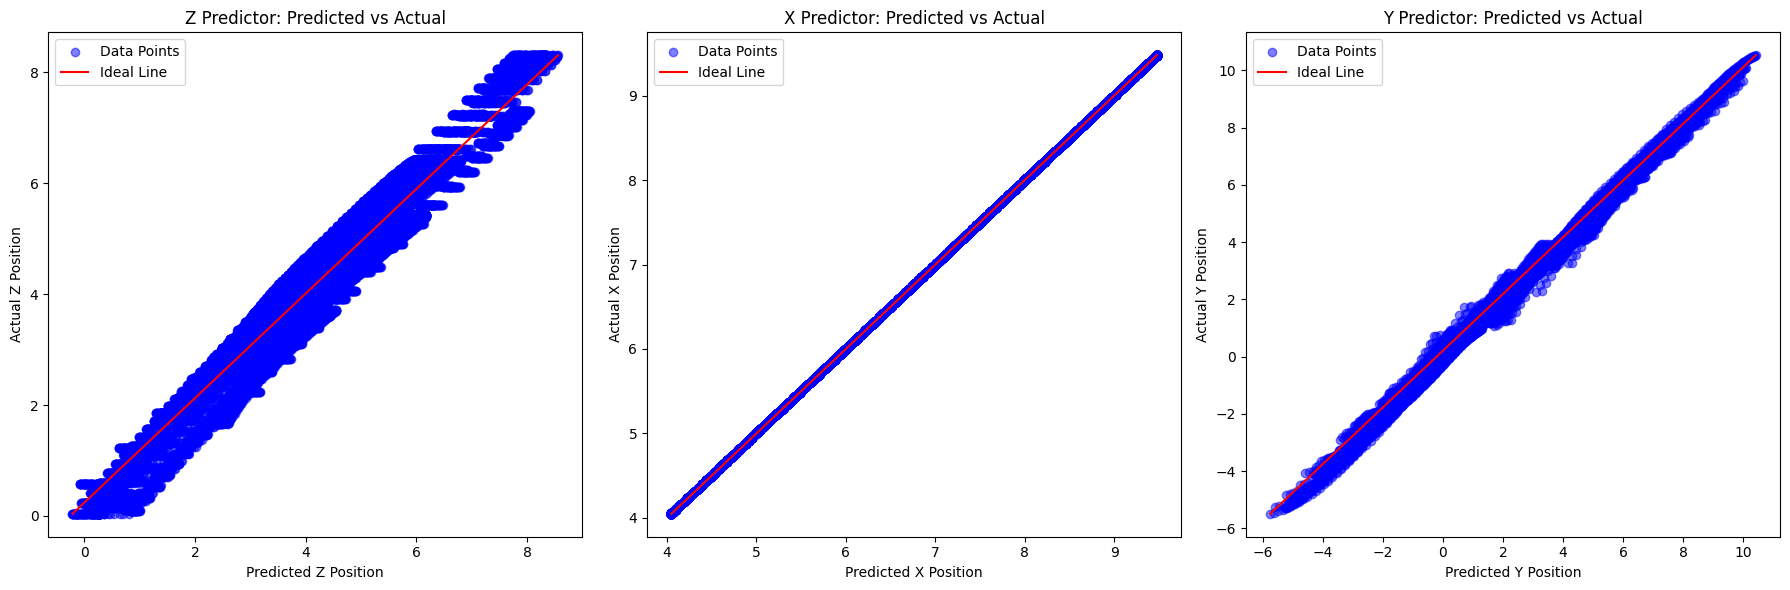

In [8]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Visualize predicted vs actual values for Z predictor
axes[0].scatter(predicted_height, y_height_test, color='blue', alpha=0.5, label='Data Points')
axes[0].plot([min(predicted_height), max(predicted_height)], [min(y_height_test), max(y_height_test)], color='red', label='Ideal Line')
axes[0].set_xlabel('Predicted Z Position')
axes[0].set_ylabel('Actual Z Position')
axes[0].set_title('Z Predictor: Predicted vs Actual')
axes[0].legend()

# Visualize predicted vs actual values for X predictor
axes[1].scatter(predicted_side, y_side_test, color='blue', alpha=0.5, label='Data Points')
axes[1].plot([min(predicted_side), max(predicted_side)], [min(y_side_test), max(y_side_test)], color='red', label='Ideal Line')
axes[1].set_xlabel('Predicted X Position')
axes[1].set_ylabel('Actual X Position')
axes[1].set_title('X Predictor: Predicted vs Actual')
axes[1].legend()

# Visualize predicted vs actual values for Y predictor
axes[2].scatter(predicted_forward, y_forward_test, color='blue', alpha=0.5, label='Data Points')
axes[2].plot([min(predicted_forward), max(predicted_forward)], [min(y_forward_test), max(y_forward_test)], color='red', label='Ideal Line')
axes[2].set_xlabel('Predicted Y Position')
axes[2].set_ylabel('Actual Y Position')
axes[2].set_title('Y Predictor: Predicted vs Actual')
axes[2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


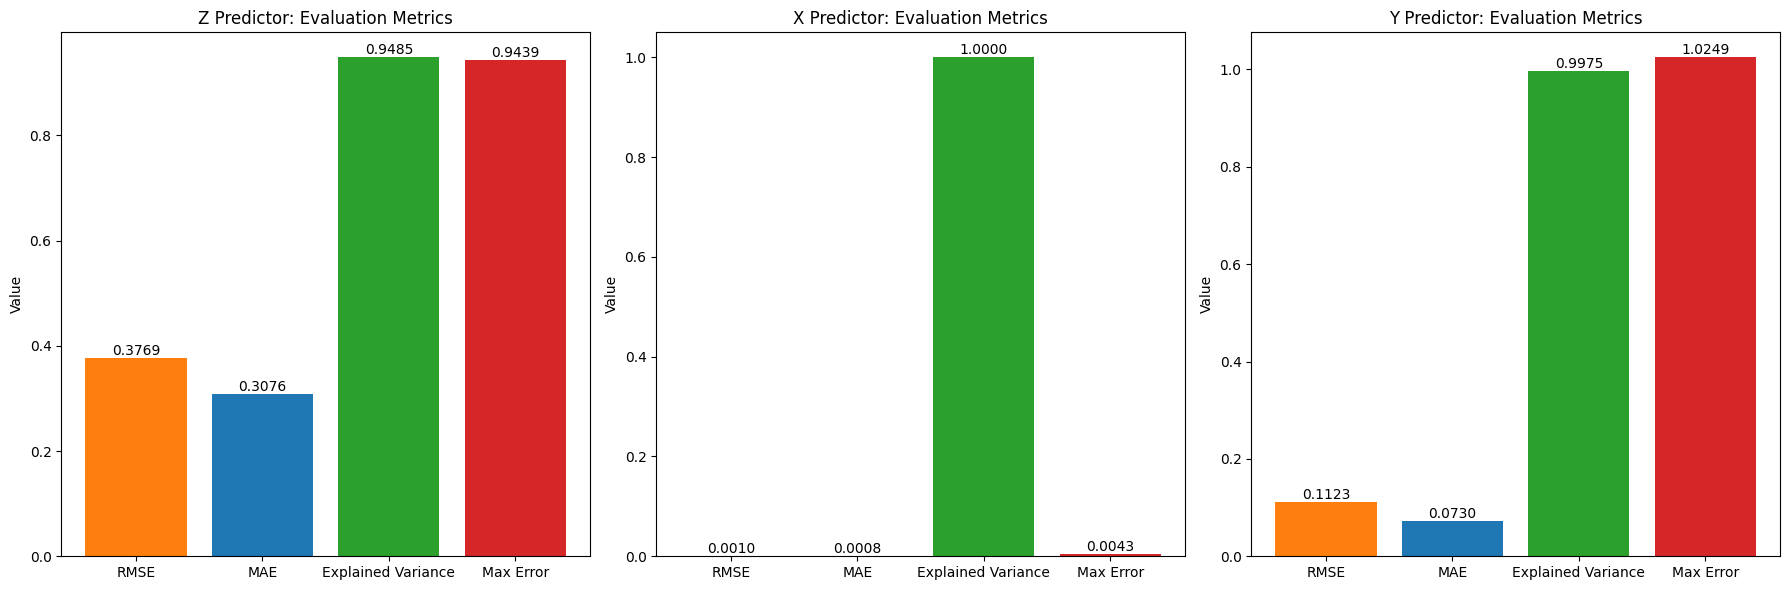

In [9]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Evaluation metric names
metrics = ['RMSE', 'MAE', 'Explained Variance', 'Max Error']

# Evaluation metric values for Z predictor
values_z = [rmse_height, mae_height, evs_height, max_error_height]

# Evaluation metric values for X predictor
values_x = [rmse_side, mae_side, evs_side, max_error_side]

# Evaluation metric values for Y predictor
values_y = [rmse_forward, mae_forward, evs_forward, max_error_forward]

# Colors for the bars
colors = ['#FF7F0E', '#1F77B4', '#2CA02C', '#D62728']

# Visualize evaluation metrics for Z predictor
axes[0].bar(metrics, values_z, color=colors)
axes[0].set_title('Z Predictor: Evaluation Metrics')
axes[0].set_ylabel('Value')

# Add data labels to the bars in Z predictor subplot
for i, v in enumerate(values_z):
    axes[0].text(i, v, f"{v:.4f}", ha='center', va='bottom')

# Visualize evaluation metrics for X predictor
axes[1].bar(metrics, values_x, color=colors)
axes[1].set_title('X Predictor: Evaluation Metrics')
axes[1].set_ylabel('Value')

# Add data labels to the bars in X predictor subplot
for i, v in enumerate(values_x):
    axes[1].text(i, v, f"{v:.4f}", ha='center', va='bottom')

# Visualize evaluation metrics for Y predictor
axes[2].bar(metrics, values_y, color=colors)
axes[2].set_title('Y Predictor: Evaluation Metrics')
axes[2].set_ylabel('Value')

# Add data labels to the bars in Y predictor subplot
for i, v in enumerate(values_y):
    axes[2].text(i, v, f"{v:.4f}", ha='center', va='bottom')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


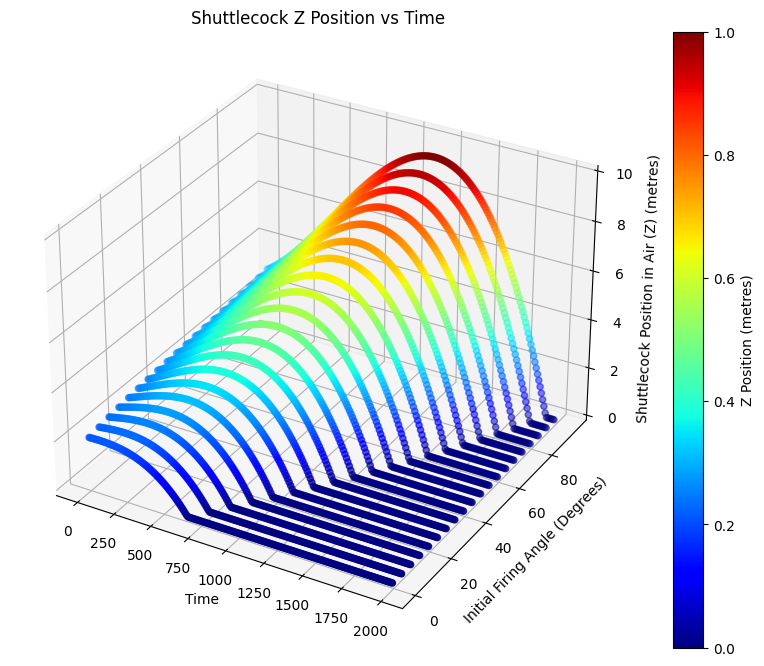

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures

# Generate sample data
angle_range = range(0, 100, 5)
time_range = range(0, 2000, 10)
sample = [[4, 1, 10, angle, 0, time] for angle in angle_range for time in time_range]

# Predict y values using a regression model
y_predictions = reg_height.predict(poly.fit_transform(sample))

# Set negative predictions to zero
y_predictions = np.maximum(y_predictions, 0)

# Create a DataFrame for the sample data
sample_df = pd.DataFrame(sample)

# Extract relevant variables
time = sample_df[5]
z_position = y_predictions
firing_angle = sample_df[3]

# Filter data points with non-negative y predictions
filtered_indices = np.where(z_position >= 0)
filtered_time = np.array(time)[filtered_indices]
filtered_z_position = np.array(z_position)[filtered_indices]
filtered_angle = np.array(firing_angle)[filtered_indices]

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set z-axis limits
ax.set_zlim(0, 10)

# Scatter plot the filtered data
ax.scatter(filtered_time, filtered_angle, filtered_z_position, c=filtered_z_position, cmap='jet')

# Set axis labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Initial Firing Angle (Degrees)')
ax.set_zlabel('Shuttlecock Position in Air (Z) (metres)')
ax.set_title('Shuttlecock Z Position vs Time')

# Add color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=ax)
cbar.set_label('Z Position (metres)')

# Display the plot
plt.show()


In [11]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Constants
ROBOT_HEIGHT = 120  # cm
ROBOT_LENGTH = 68  # cm
ROBOT_WIDTH = 23  # cm
ROBOT_SPEED = 300  # cm/sec, converted from 3 m/s
ROBOT_MOVE_TIME = 1.5  # seconds

# Generate three random initial positions for the robot
initial_positions = np.random.rand(3, 3) * 300  # Generating 3 random 3D positions (in cm)

def calculate_estimated_position(pred_height, pred_side, pred_forward):
    shuttlecock_height = pred_height + ROBOT_HEIGHT
    shuttlecock_side = pred_side
    shuttlecock_forward = pred_forward

    return np.array([
        shuttlecock_side - ROBOT_LENGTH / 2,  # X coordinate
        shuttlecock_forward,  # Y coordinate
        shuttlecock_height + ROBOT_WIDTH / 2  # Z coordinate
    ])

def calculate_motion_control(robot_position, estimated_position):
    distance = np.linalg.norm(estimated_position - robot_position)
    movement_time = min(distance / ROBOT_SPEED, ROBOT_MOVE_TIME)
    direction_vector = (estimated_position - robot_position) / distance
    movement_vector = direction_vector * ROBOT_SPEED * movement_time
    final_position = robot_position + movement_vector
    return final_position, movement_time

def find_highest_point(pred_height):
    return np.argmax(pred_height)  # Returns the index of the highest predicted height

def generate_robot_motion_code(X_test_poly):
    y_height_test_pred = reg_height.predict(X_test_poly)
    y_side_test_pred = reg_side.predict(X_test_poly)
    y_forward_test_pred = reg_forward.predict(X_test_poly)

    for pos, pred_height, pred_side, pred_forward in zip(initial_positions, y_height_test_pred, y_side_test_pred, y_forward_test_pred):
        estimated_position = calculate_estimated_position(pred_height, pred_side, pred_forward)
        final_position, movement_time = calculate_motion_control(pos, estimated_position)

        print("Robot Initial Position:", pos)
        print("Estimated Position:", estimated_position)
        print("Robot Final Position:", final_position)
        print("Movement Time (sec):", movement_time)
        print()


def evaluate_performance(X_test_poly, y_height_test, y_side_test, y_forward_test):
    y_height_test_pred = reg_height.predict(X_test_poly)
    y_side_test_pred = reg_side.predict(X_test_poly)
    y_forward_test_pred = reg_forward.predict(X_test_poly)

    height_error = mean_absolute_error(y_height_test, y_height_test_pred)
    side_error = mean_absolute_error(y_side_test, y_side_test_pred)
    forward_error = mean_absolute_error(y_forward_test, y_forward_test_pred)

    print("Height Error (cm):", height_error)
    print("Side Error (cm):", side_error)
    print("Forward Error (cm):", forward_error)

# You can call the functions to generate the code for trajectory prediction, robot motion control, and performance evaluation
generate_robot_motion_code(X_test_poly)

# Assume y_height_test, y_side_test, y_forward_test are your true labels
y_height_test_pred = reg_height.predict(X_test_poly)
y_side_test_pred = reg_side.predict(X_test_poly)
y_forward_test_pred = reg_forward.predict(X_test_poly)

# Compute errors
height_error = mean_absolute_error(y_height_test, y_height_test_pred)
side_error = mean_absolute_error(y_side_test, y_side_test_pred)
forward_error = mean_absolute_error(y_forward_test, y_forward_test_pred)

# Check if the error is within 1 cm
if all(error <= 1 for error in [height_error, side_error, forward_error]):
    print("The prediction accuracy is within 1 cm deviation\n")
else:
    print("The prediction accuracy exceeds 1 cm deviation\n")

evaluate_performance(X_test_poly, y_height_test, y_side_test, y_forward_test)


Robot Initial Position: [224.75341782 117.74325203 183.74330794]
Estimated Position: [-29.76317063   1.23668479 134.39025088]
Robot Final Position: [-29.76317063   1.23668479 134.39025088]
Movement Time (sec): 0.9474421603243354

Robot Initial Position: [291.25535087 194.32472625  64.25179962]
Estimated Position: [-29.53149584   1.30833043 134.93631818]
Robot Final Position: [-29.53149584   1.30833043 134.93631818]
Movement Time (sec): 1.2699773893068071

Robot Initial Position: [184.71765082 148.77108055  61.53548705]
Estimated Position: [-29.30498076   1.37965435 135.45003536]
Robot Final Position: [-29.30498076   1.37965435 135.45003536]
Movement Time (sec): 0.9005756171088363

The prediction accuracy is within 1 cm deviation

Height Error (cm): 0.30757079789957986
Side Error (cm): 0.00079558644197449
Forward Error (cm): 0.07296522062893641
